<a href="https://colab.research.google.com/github/TharinduGee/Prediction_Models/blob/main/Corbon_emission_predictor_Only_using_numeric_features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [91]:
import numpy as np;
import pandas as pd;
import matplotlib.pyplot as plt;
import tensorflow as tf;

In [34]:
record = pd.read_excel('https://www.epa.gov/system/files/documents/2022-04/22-tstcar-2022-04-15.xlsx');


In [21]:
target = record.pop("CO2 (g/mi)")
target = target.fillna(method= 'ffill',axis='rows')


In [44]:
record = record.dropna(thresh = 3000, axis='columns')


record = record.fillna(method= 'ffill',axis='rows')

record

,Model Year,Vehicle Manufacturer Name,Veh Mfr Code,Represented Test Veh Make,Represented Test Veh Model,Test Vehicle ID,Test Veh Configuration #,Test Veh Displacement (L),Actual Tested Testgroup,Vehicle Type,...,Target Coef B (lbf/mph),Target Coef C (lbf/mph**2),Set Coef A (lbf),Set Coef B (lbf/mph),Set Coef C (lbf/mph**2),Aftertreatment Device Cd,Aftertreatment Device Desc,Police - Emergency Vehicle?,Averaging Method Cd,Averging Method Desc
0,2022,aston martin,ASX,Aston Martin,DB11 V8,562TT5348,0,4.000,JASXV04.0AES,Car,...,0.0169,0.02710,11.26,0.09190,0.025100,TWC,Three-way catalyst,N,N,No averaging
1,2022,aston martin,ASX,Aston Martin,DB11 V8,562TT5348,0,4.000,JASXV04.0AES,Car,...,0.0169,0.02710,11.26,0.09190,0.025100,TWC,Three-way catalyst,N,N,No averaging
2,2022,aston martin,ASX,Aston Martin,DBS,7002PT7056,0,5.200,KASXV05.2AM5,Car,...,0.0169,0.02710,6.81,0.08070,0.024500,TWC,Three-way catalyst,N,N,No averaging
3,2022,aston martin,ASX,Aston Martin,DBS,7002PT7056,0,5.200,KASXV05.2AM5,Car,...,0.0169,0.02710,6.81,0.08070,0.024500,TWC,Three-way catalyst,N,N,No averaging
4,2022,aston martin,ASX,Aston Martin,DBX,8001PT8342,1,4.000,MASXJ04.0AEX,Both,...,-0.3286,0.03730,-4.88,-0.53180,0.036700,TWC,Three-way catalyst,N,N,No averaging
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4392,2022,Volvo,VVX,Volvo,XC90 T8 AWD Recharge Extended Range,202211,1,1.969,NVVXJ02.0P3L,Both,...,0.3540,0.02482,-4.03,0.40441,0.022373,TWC,Three-way catalyst,N,N,No averaging
4393,2022,Volvo,VVX,Volvo,XC90 T8 AWD Recharge Extended Range,202211,1,1.969,NVVXJ02.0P3L,Both,...,0.3540,0.02482,-4.03,0.40441,0.022373,TWC,Three-way catalyst,N,N,No averaging
4394,2022,Volvo,VVX,Volvo,XC90 T8 AWD Recharge Extended Range,202211,1,1.969,NVVXJ02.0P3L,Both,...,0.3540,0.02482,-4.03,0.40441,0.022373,TWC,Three-way catalyst,N,N,No averaging
4395,2022,Volvo,VVX,Volvo,XC90 T8 AWD Recharge Extended Range,202211,1,1.969,NVVXJ02.0P3L,Both,...,0.3540,0.02482,-4.03,0.40441,0.022373,TWC,Three-way catalyst,N,N,No averaging


In [50]:
numeric_feature_names = []
for name in record.columns:
  if record[name].dtype != object:
    numeric_feature_names.append(name)

numeric_feature_names

['Model Year',
 'Test Veh Configuration #',
 'Test Veh Displacement (L)',
 'Rated Horsepower',
 '# of Cylinders and Rotors',
 '# of Gears',
 'Transmission Overdrive Code',
 'Equivalent Test Weight (lbs.)',
 'Axle Ratio',
 'N/V Ratio',
 'Shift Indicator Light Use Cd',
 'Test Procedure Cd',
 'Test Fuel Type Cd',
 'THC (g/mi)',
 'CO (g/mi)',
 'CO2 (g/mi)',
 'NOx (g/mi)',
 'CH4 (g/mi)',
 'RND_ADJ_FE',
 'DT-Inertia Work Ratio Rating',
 'DT-Absolute Speed Change Ratg',
 'DT-Energy Economy Rating',
 'Target Coef A (lbf)',
 'Target Coef B (lbf/mph)',
 'Target Coef C (lbf/mph**2)',
 'Set Coef A (lbf)',
 'Set Coef B (lbf/mph)',
 'Set Coef C (lbf/mph**2)']

In [54]:
numeric_features = record[numeric_feature_names]
numeric_features.head()

,Model Year,Test Veh Configuration #,Test Veh Displacement (L),Rated Horsepower,# of Cylinders and Rotors,# of Gears,Transmission Overdrive Code,Equivalent Test Weight (lbs.),Axle Ratio,N/V Ratio,...,RND_ADJ_FE,DT-Inertia Work Ratio Rating,DT-Absolute Speed Change Ratg,DT-Energy Economy Rating,Target Coef A (lbf),Target Coef B (lbf/mph),Target Coef C (lbf/mph**2),Set Coef A (lbf),Set Coef B (lbf/mph),Set Coef C (lbf/mph**2)
0,2022,0,4.0,503,8.0,8,2,4500,2.70,22.2,...,22.7,-11.99,-9.26,-7.71,40.94,0.0169,0.0271,11.26,0.0919,0.0251
1,2022,0,4.0,503,8.0,8,2,4500,2.70,22.2,...,33.8,-3.64,-3.21,-0.96,40.94,0.0169,0.0271,11.26,0.0919,0.0251
2,2022,0,5.2,715,12.0,8,2,4500,2.93,23.0,...,17.7,-0.95,-0.56,-0.58,40.94,0.0169,0.0271,6.81,0.0807,0.0245
3,2022,0,5.2,715,12.0,8,2,4500,2.93,23.0,...,30.6,-2.45,-2.15,-0.08,40.94,0.0169,0.0271,6.81,0.0807,0.0245
4,2022,1,4.0,550,8.0,9,2,5500,3.06,21.0,...,17.2,-3.10,-2.44,-2.11,60.68,-0.3286,0.0373,-4.88,-0.5318,0.0367


In [55]:
tf.convert_to_tensor(numeric_features)

<tf.Tensor: shape=(4397, 28), dtype=float64, numpy=
array([[ 2.0220e+03,  0.0000e+00,  4.0000e+00, ...,  1.1260e+01,
         9.1900e-02,  2.5100e-02],
       [ 2.0220e+03,  0.0000e+00,  4.0000e+00, ...,  1.1260e+01,
         9.1900e-02,  2.5100e-02],
       [ 2.0220e+03,  0.0000e+00,  5.2000e+00, ...,  6.8100e+00,
         8.0700e-02,  2.4500e-02],
       ...,
       [ 2.0220e+03,  1.0000e+00,  1.9690e+00, ..., -4.0300e+00,
         4.0441e-01,  2.2373e-02],
       [ 2.0220e+03,  1.0000e+00,  1.9690e+00, ..., -4.0300e+00,
         4.0441e-01,  2.2373e-02],
       [ 2.0220e+03,  1.0000e+00,  1.9690e+00, ..., -4.0300e+00,
         4.0441e-01,  2.2373e-02]])>

In [56]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(numeric_features)

In [57]:
normalizer(numeric_features.iloc[:3])

<tf.Tensor: shape=(3, 28), dtype=float32, numpy=
array([[ 0.4364287 , -0.6493246 ,  0.09781533,  1.1432147 ,  1.4019766 ,
         0.43865785,  0.2501782 , -0.0513504 , -0.80080426, -0.25066543,
        -0.17679274, -0.26734242,  0.32082927,  0.0290859 , -0.3537497 ,
         0.59668297,  1.3112551 ,  0.02201664, -0.08486825, -1.4370627 ,
        -1.1593299 , -0.86548686,  0.12797132, -0.7591113 ,  0.28259566,
         0.210423  , -0.01446142,  0.11847712],
       [ 0.4364287 , -0.6493246 ,  0.09781533,  1.1432147 ,  1.4019766 ,
         0.43865785,  0.2501782 , -0.0513504 , -0.80080426, -0.25066543,
        -0.17679274, -0.80635864,  0.32082927, -0.41117683, -0.3936452 ,
        -0.46141443, -0.60875916,  0.02201664, -0.06603594, -0.52817917,
        -0.48210943, -0.16828305,  0.12797132, -0.7591113 ,  0.28259566,
         0.210423  , -0.01446142,  0.11847712],
       [ 0.4364287 , -0.6493246 ,  0.27709767,  2.449823  ,  3.6114721 ,
         0.43865785,  0.2501782 , -0.0513504 , -0.61

In [78]:
def get_basic_model():
  model = tf.keras.Sequential([
    normalizer,
    tf.keras.layers.Dense(56, activation='relu'),
    tf.keras.layers.Dense(28, activation='relu'),
    tf.keras.layers.Dense(1)
  ])

  # model.compile(optimizer='adam',
  #               loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
  #               metrics=['accuracy'])
  
  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [95]:
model = get_basic_model()
history = model.fit(numeric_features, target,validation_split = 0.2, verbose=0,  epochs=25, batch_size=5)

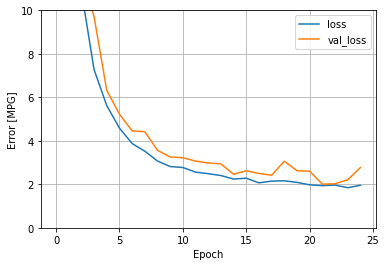

In [96]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

plot_loss(history)

In [ ]:
test_results['dnn_model'] = model.evaluate(test_features, test_labels, verbose=0)

In [98]:
test_predictions = model.predict(numeric_features).flatten()


In [99]:
test_predictions

array([387.02264, 258.59552, 501.7203 , ..., 256.49588, 267.0937 ,
       224.95682], dtype=float32)